In [21]:
# need to install in terminal
# pip install torch torchtuples lifelines
# pip install pyarrow


In [22]:
# imports
import pandas as pd
import numpy as np
# import torch
import torch.nn as nn
import torchtuples as tt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.mixture import GaussianMixture

In [23]:
# load dataset
df = pd.read_csv("../../data/raw/air_12318.csv", on_bad_lines='skip')
df = df.sort_values("time").reset_index(drop=True) #sort by date

numeric_cols = [
    'va_V','vb_V','vc_V','va-vb_V','vb-vc_V','vc-va_V',
    'mVa_V','mVb_V','mVc_v','mVa-mBb_V','mVb-mVc_V','mVc-mVa_V',
    'ia_A','ib_A','ic_A','pa_W','pb_W','pc_W','ptot_W',
    'qa_Var','qb_Var','qc_Var','qtot_Var','sa_VA','sb_VA','sc_VA','stot_VA',
    'pfa_None','pfb_None','pfc_None','pftot_None','freq_Hz*10',
    'temp_Degrees Celsius','pressure_Bar','fuel_%','vbat_V'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Sort and detect running
p = df['ptot_W'].clip(lower=0).fillna(0)
X = np.log1p(p).values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)
means = gmm.means_.flatten()
on_cluster = np.argmax(means)

# running detection
df['is_running_gmm'] = (labels == on_cluster).astype(int)
df['any_current'] = df[['ia_A','ib_A','ic_A']].sum(axis=1) > 0.1 # cross-check with currents
df['is_running'] = ((df['is_running_gmm'] == 1) | df['any_current']).astype(int)

df_running = df[df['is_running_gmm'] == 1].copy()
# df_running.to_csv("is_runningDataset.csv", index=False) used for testing and debugging

In [24]:
valid_ranges = {
    # Mains voltages (from grid)
    "mVa_V": (180, 260),
    "mVb_V": (180, 260),
    "mVc_v": (180, 260),

    # Mains line-to-line voltages
    "mVa-mBb_V": (380, 460),
    "mVb-mVc_V": (380, 460),
    "mVc-mVa_V": (380, 460),

    # Generator voltages (phase-to-neutral)
    "va_V": (180, 260),
    "vb_V": (180, 260),
    "vc_V": (180, 260),

    # Generator line-to-line voltages
    "va-vb_V": (380, 460),
    "vb-vc_V": (380, 460),
    "vc-va_V": (380, 460),

    # Currents
    "ia_A": (0, 400),
    "ib_A": (0, 400),
    "ic_A": (0, 400),

    # Active power
    "pa_W": (0, 50000),
    "pb_W": (0, 50000),
    "pc_W": (0, 50000),
    "ptot_W": (0, 150000),

    # Reactive and apparent power
    "qa_Var": (-50000, 50000),
    "qb_Var": (-50000, 50000),
    "qc_Var": (-50000, 50000),
    "sa_VA": (0, 60000),
    "sb_VA": (0, 60000),
    "sc_VA": (0, 60000),

    # Totals
    "qtot_Var": (-50000, 50000),
    "stot_VA": (0, 150000),

    # Power factor
    "pfa_None": (0.8, 1.0),
    "pfb_None": (0.8, 1.0),
    "pfc_None": (0.8, 1.0),
    "pftot_None": (0.8, 1.0),

    # Frequency (scaled ×10)
    "freq_Hz*10": (450, 550),

    # Engine & sensors
    "temp_Degrees Celsius": (-50, 120),
    "pressure_Bar": (0, 10),
    "fuel_%": (0, 130),
    "vbat_V": (10, 15)
}
# clean the data
for col, (low, high) in valid_ranges.items():
    if col in df_running.columns:
        mask = df_running[col].between(low, high)
        df_running.loc[~mask, col] = np.nan  # set invalid readings to NaN 


In [25]:
df_running.isna().sum()

id                          0
time                        0
epoch                       0
air                         0
device                      0
mVa_V                   12808
mVb_V                   12808
mVc_v                   12808
mVa-mBb_V               12808
mVb-mVc_V               12808
mVc-mVa_V               12808
va_V                        0
vb_V                        0
vc_V                        0
va-vb_V                     1
vb-vc_V                     1
vc-va_V                     1
ia_A                        0
ib_A                        0
ic_A                        0
pa_W                        0
pb_W                        0
pc_W                        0
qa_Var                      0
qb_Var                      0
qc_Var                      0
sa_VA                       0
sb_VA                       0
sc_VA                       0
ptot_W                      0
qtot_Var                    0
stot_VA                     0
pfa_None                12817
pfb_None  

In [26]:
# drop columns with too many nans
nan_columns_to_drop = [
    'mVa_V', 'mVb_V', 'mVc_v',
    'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V',
    'va-vb_V', 'vb-vc_V', 'vc-va_V',
    'pfa_None', 'pfb_None', 'pfc_None', 'pftot_None',
    'pressure_Bar', 'vbat_V'
]

df_running = df_running.drop(columns=nan_columns_to_drop)


In [27]:
# calculate thresholds using mean +/- 3*std
thresholds = {}
for col in numeric_cols:
    if col in df_running.columns:
        series = df_running[col].dropna()
        if len(series) == 0:  # skip columns with no valid data
            continue
        mean, std = series.mean(), series.std()
        lower = max(mean - 3*std, valid_ranges.get(col, (mean - 3*std, mean + 3*std))[0])
        upper = min(mean + 3*std, valid_ranges.get(col, (mean - 3*std, mean + 3*std))[1])
        thresholds[col] = {
            "mean": mean, 
            "std": std,
            "lower": lower,
            "upper": upper
        }

thresholds_df = pd.DataFrame(thresholds).T
thresholds_df = thresholds_df.dropna(how='all') #drop nan columns
print(thresholds_df)

                              mean           std         lower         upper
va_V                    231.188032      0.801102    228.784727    233.591336
vb_V                    231.181868      0.659670    229.202858    233.160877
vc_V                    232.112039      0.910351    229.380986    234.843091
ia_A                     54.079582     31.611736      0.000000    148.914791
ib_A                     29.195834     20.115065      0.000000     89.541028
ic_A                     29.630803     23.252648      0.000000     99.388746
pa_W                  12028.861278   6904.929316      0.000000  32743.649227
pb_W                   6475.854646   4331.666872      0.000000  19470.855264
pc_W                   6538.675977   4980.065828      0.000000  21478.873462
ptot_W                25046.661855  15733.421079      0.000000  72246.925093
qa_Var                 3603.378482   2661.201324  -4380.225492  11586.982455
qb_Var                 2155.797144   1890.441510  -3515.527386   7827.121675

In [28]:
# Initialize
df_running['event'] = 0
df_running['event_cols'] = ""
df_running['event_severity'] = 0.0

for col in thresholds_df.index:
    lower = thresholds_df.loc[col, 'lower']
    upper = thresholds_df.loc[col, 'upper']

    # Mask where the column exceeds thresholds
    mask = (df_running[col] < lower) | (df_running[col] > upper)

    # Flag events
    df_running.loc[mask, 'event'] = 1

    # Add triggered column info
    df_running.loc[mask, 'event_cols'] = df_running.loc[mask, 'event_cols'] + \
        df_running.loc[mask].apply(lambda row: f"{col}={row[col]} [{lower}, {upper}]", axis=1) + ", "

    # Compute severity (distance from closest threshold)
    severity = df_running[col].where(df_running[col] < lower, df_running[col] - upper).abs()
    df_running.loc[mask, 'event_severity'] = df_running.loc[mask, 'event_severity'].combine(severity, max)

# Remove trailing comma in event_cols
df_running['event_cols'] = df_running['event_cols'].str.rstrip(", ")


# Display first 20 rows
print(df_running[['time', 'is_running', 'event', 'event_cols', 'event_severity']].head(20))

# Totals
total_running = df_running['is_running'].sum()
total_events = df_running['event'].sum()
print(f"\nTotal rows with generator running: {total_running}")
print(f"Total number of events: {total_events}")


                          time  is_running  event event_cols  event_severity
226  2023-02-28 18:02:55+00:00           1      0                        0.0
227  2023-02-28 18:04:58+00:00           1      0                        0.0
228  2023-02-28 18:08:59+00:00           1      0                        0.0
229  2023-02-28 18:10:54+00:00           1      0                        0.0
230  2023-02-28 18:12:55+00:00           1      0                        0.0
231  2023-02-28 18:14:54+00:00           1      0                        0.0
232  2023-02-28 18:16:54+00:00           1      0                        0.0
233  2023-02-28 18:18:54+00:00           1      0                        0.0
234  2023-02-28 18:20:54+00:00           1      0                        0.0
235  2023-02-28 18:22:54+00:00           1      0                        0.0
236  2023-02-28 18:24:54+00:00           1      0                        0.0
237  2023-02-28 18:26:53+00:00           1      0                        0.0

In [29]:
existing_numeric_cols = [col for col in numeric_cols if col in df_running.columns]

intervals = []
healthy_start = None
metrics_accum = []

for idx, row in df_running.iterrows():
    if row['event'] == 0:  # healthy row
        if healthy_start is None:
            healthy_start = row['time']
            metrics_accum = [row[existing_numeric_cols].to_dict()]
        else:
            metrics_accum.append(row[existing_numeric_cols].to_dict())
    else:  # event row
        if healthy_start is not None:
            start_time = healthy_start
            end_time = row['time']
            duration = (pd.to_datetime(end_time) - pd.to_datetime(start_time)).total_seconds()
            
            # Aggregate metrics over interval
            metrics_df = pd.DataFrame(metrics_accum)
            metrics_agg = metrics_df.mean(skipna=True).to_dict()
            
            intervals.append({
                'start_time': start_time,
                'end_time': end_time,
                'duration_seconds': duration,
                'event_observed': 1,
                **metrics_agg
            })
            
            healthy_start = None
            metrics_accum = []

# Handle last healthy interval if generator did not fail
if healthy_start is not None:
    start_time = healthy_start
    end_time = df_running['time'].iloc[-1]
    duration = (pd.to_datetime(end_time) - pd.to_datetime(start_time)).total_seconds()
    
    metrics_df = pd.DataFrame(metrics_accum)
    metrics_agg = metrics_df.mean(skipna=True).to_dict()
    
    intervals.append({
        'start_time': start_time,
        'end_time': end_time,
        'duration_seconds': duration,
        'event_observed': 0,
        **metrics_agg
    })

# Create final survival dataframe
survival_df = pd.DataFrame(intervals)

# Save to CSV
survival_df.to_csv("../../data/processed/survival_intervals_12318.csv", index=False)

print(survival_df.head(20))
print(f"Total healthy intervals: {len(survival_df)}")


                   start_time                   end_time  duration_seconds  \
0   2023-02-28 18:02:55+00:00  2023-02-28 20:00:52+00:00            7077.0   
1   2023-02-28 20:02:52+00:00  2023-03-01 14:21:43+00:00           65931.0   
2   2023-03-01 14:35:43+00:00  2023-03-01 14:39:43+00:00             240.0   
3   2023-03-01 14:55:43+00:00  2023-03-01 15:17:41+00:00            1318.0   
4   2023-03-01 15:27:41+00:00  2023-03-01 15:39:41+00:00             720.0   
5   2023-03-01 15:41:41+00:00  2023-03-01 15:43:41+00:00             120.0   
6   2023-03-01 15:55:42+00:00  2023-03-02 06:17:59+00:00           51737.0   
7   2023-03-02 06:19:59+00:00  2023-03-02 07:01:59+00:00            2520.0   
8   2023-03-02 07:05:59+00:00  2023-03-02 07:07:59+00:00             120.0   
9   2023-03-02 07:17:59+00:00  2023-03-02 07:19:59+00:00             120.0   
10  2023-03-02 07:41:58+00:00  2023-03-02 07:45:58+00:00             240.0   
11  2023-03-02 14:07:28+00:00  2023-03-02 14:09:29+00:00        

In [30]:
# preprocessing
# Load data
df = pd.read_csv("../../data/processed/survival_intervals_12318.csv")

# Features
features = existing_numeric_cols  # or subset you want to include
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Targets
y = df[['duration_seconds', 'event_observed']].to_numpy()

In [31]:
# split data into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [32]:
import torchtuples as tt
from pycox.models import CoxPH
import torch

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Duration and event tensors
durations_train = torch.tensor(y_train[:, 0], dtype=torch.float32)
events_train = torch.tensor(y_train[:, 1], dtype=torch.float32)


In [33]:
from torch import nn

# Network architecture
num_features = X_train.shape[1]
net = tt.practical.MLPVanilla(num_features, [64, 32], 1, activation=nn.ReLU)

# CoxPH model with DeepSurv
model = CoxPH(net, tt.optim.Adam)


In [34]:
from torchtuples.callbacks import EarlyStopping

# Early stopping callback to avoid overfitting
callbacks = [EarlyStopping(patience=10)]

# Fit the model
log = model.fit(
    X_train_tensor,
    (durations_train, events_train),
    batch_size=64,
    epochs=200,  # can adjust depending on dataset size
    callbacks=callbacks,
    verbose=True,
    val_data=(X_test_tensor, (torch.tensor(y_test[:,0], dtype=torch.float32),
                              torch.tensor(y_test[:,1], dtype=torch.float32)))
)


0:	[0s / 0s],		train_loss: 2.8653,	val_loss: 2.2626
1:	[0s / 0s],		train_loss: 2.6930,	val_loss: 2.1947
2:	[0s / 0s],		train_loss: 2.6541,	val_loss: 2.1289
3:	[0s / 0s],		train_loss: 2.4729,	val_loss: 2.0681
4:	[0s / 0s],		train_loss: 2.4974,	val_loss: 2.0136
5:	[0s / 0s],		train_loss: 2.3342,	val_loss: 1.9665
6:	[0s / 0s],		train_loss: 2.3348,	val_loss: 1.9287
7:	[0s / 0s],		train_loss: 2.3847,	val_loss: 1.8965
8:	[0s / 0s],		train_loss: 2.2685,	val_loss: 1.8676
9:	[0s / 0s],		train_loss: 2.2731,	val_loss: 1.8468
10:	[0s / 0s],		train_loss: 2.1809,	val_loss: 1.8302
11:	[0s / 0s],		train_loss: 2.1685,	val_loss: 1.8150
12:	[0s / 0s],		train_loss: 2.0875,	val_loss: 1.8029
13:	[0s / 0s],		train_loss: 2.0550,	val_loss: 1.7910
14:	[0s / 0s],		train_loss: 2.1285,	val_loss: 1.7789
15:	[0s / 0s],		train_loss: 2.0973,	val_loss: 1.7722
16:	[0s / 0s],		train_loss: 2.0967,	val_loss: 1.7683
17:	[0s / 0s],		train_loss: 2.0488,	val_loss: 1.7625
18:	[0s / 0s],		train_loss: 2.0088,	val_loss: 1.7596
19:

In [35]:
from lifelines.utils import concordance_index

# Predict risk scores
risk_scores = model.predict(X_test_tensor).detach().numpy().flatten()

# Compute C-index (negative because higher risk → shorter survival)
c_index = concordance_index(y_test[:, 0], -risk_scores, y_test[:, 1])
print(f"C-index (higher is better): {c_index:.4f}")


C-index (higher is better): 0.8739


In [36]:
# Compute baseline hazards after training
model.compute_baseline_hazards()

# Now predict survival functions
surv_df = model.predict_surv_df(X_test_tensor)  # pandas DataFrame

from pycox.evaluation import EvalSurv

ev = EvalSurv(surv_df, y_test[:, 0], y_test[:, 1], censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f"C-index (higher is better): {c_index:.4f}")


C-index (higher is better): 0.8739


In [37]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicted RUL (median survival time)
rul_pred = surv_df.median(axis=0).values

# Actual RUL for test set
rul_true = y_test[:, 0]

# Compute errors
mae = mean_absolute_error(rul_true, rul_pred)
mse = mean_squared_error(rul_true, rul_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")

# Optional: compare a few samples
for i in range(10):
    print(f"Actual: {rul_true[i]:.2f}, Predicted: {rul_pred[i]:.2f}")


Mean Absolute Error (MAE): 310318.14 seconds
Root Mean Squared Error (RMSE): 1288084.40 seconds
Actual: 601.00, Predicted: 0.24
Actual: 240.00, Predicted: 0.00
Actual: 720.00, Predicted: 0.00
Actual: 10920.00, Predicted: 0.48
Actual: 120.00, Predicted: 0.00
Actual: 1319.00, Predicted: 0.00
Actual: 240.00, Predicted: 0.00
Actual: 240.00, Predicted: 0.00
Actual: 35931.00, Predicted: 0.55
Actual: 121.00, Predicted: 0.00


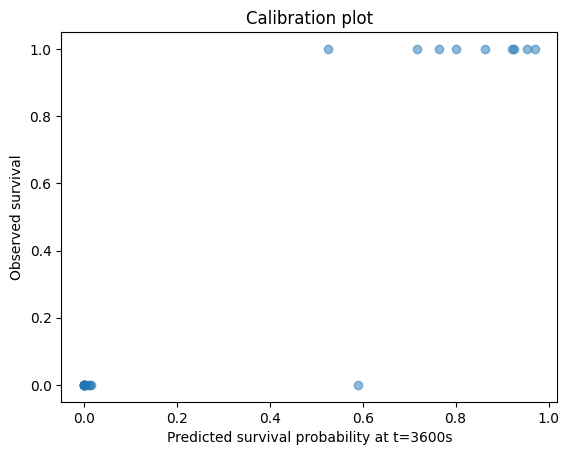

In [38]:
import matplotlib.pyplot as plt
time_horizon = 3600
closest_time = surv_df.index.get_indexer([time_horizon], method='nearest')[0]
closest_time = surv_df.index[closest_time]
pred_surv_probs = surv_df.loc[closest_time]

observed = (rul_true > time_horizon).astype(int)

plt.scatter(pred_surv_probs, observed, alpha=0.5)
plt.xlabel(f'Predicted survival probability at t={time_horizon}s')
plt.ylabel('Observed survival')
plt.title('Calibration plot')
plt.show()


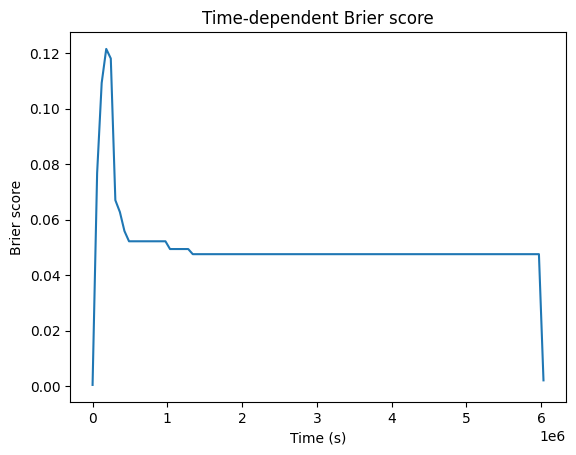

In [39]:
from pycox.evaluation import EvalSurv

ev = EvalSurv(surv_df, y_test[:, 0], y_test[:, 1], censor_surv='km')
times = np.linspace(0, rul_true.max(), 100)
brier_scores = ev.brier_score(times)
plt.plot(times, brier_scores)
plt.xlabel('Time (s)')
plt.ylabel('Brier score')
plt.title('Time-dependent Brier score')
plt.show()


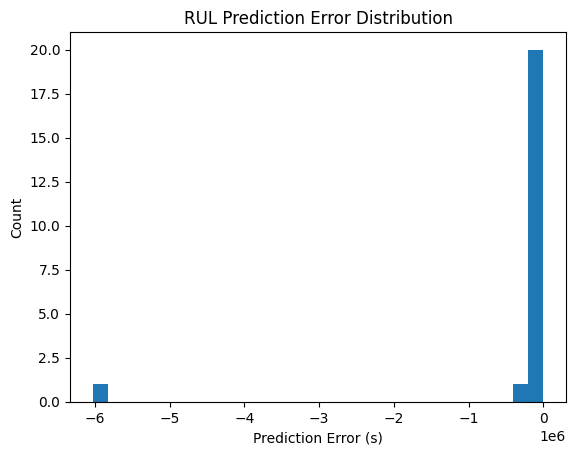

In [40]:
errors = rul_pred - rul_true
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (s)')
plt.ylabel('Count')
plt.title('RUL Prediction Error Distribution')
plt.show()


Convert to onnx for server use

In [41]:
import torch.onnx

dummy_input = torch.tensor(X_test[:1], dtype=torch.float32)

# Export the network (net) part only
torch.onnx.export(
    model.net,
    dummy_input,
    "deepsurv_model.onnx",
    input_names=['features'],
    output_names=['risk'],
    dynamic_axes={'features': {0: 'batch_size'}, 'risk': {0: 'batch_size'}}
)


C:\Users\tarin\AppData\Local\Temp\ipykernel_17896\3381403418.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [42]:
import joblib

joblib.dump(scaler, "scaler.save")


['scaler.save']